In [1]:
!pip install av
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 33.9 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
from fastai.vision.all import *
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# descargamos los datos
!gdown XXXXXXxxxxxXXXxxx



In [5]:
# descomprimimos el zip
!unzip -qq data.zip -d tfm-data

mapname:  conversion of  failed


In [6]:
# cargamos el dataset con el FEVI por cada video
df = pd.read_csv('/content/tfm-data/target.csv')
df.head()

FileName       FEVI
0  0X1A030EFDD45062FA  44.485700
1   0X1A05829AEDF6C65  64.078050
2  0X1A05DFFFCAFB253B  65.143601
3  0X1A09BE7969DA1508  69.566347
4  0X1A0A263B22CCD966  65.454529

In [7]:
# asignamos target 1 a pacientes con FEVI < 50
df['target'] = np.where(df['FEVI'] < 50, 1, 0)
df['target'].value_counts()

0    1151
1     329
Name: target, dtype: int64

In [8]:
df['FEVI10'] = df['FEVI'] // 10
df.loc[df['FEVI10'] == 0, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 1, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 2, 'FEVI10'] = 3
df.loc[df['FEVI10'] == 8, 'FEVI10'] = 6
df.loc[df['FEVI10'] == 7, 'FEVI10'] = 6
df['FEVI10'].value_counts()

6.0    685
5.0    466
3.0    195
4.0    134
Name: FEVI10, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FileName  1480 non-null   object 
 1   FEVI      1480 non-null   float64
 2   target    1480 non-null   int64  
 3   FEVI10    1480 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 46.4+ KB


In [10]:
# vamos a trabajar en el directorio en el que están los datos
%cd ./tfm-data

/content/tfm-data


In [11]:
# usamos Path para acceder más fácilmente
data_path = Path('./videos')
data_path.ls()

(#1480) [Path('videos/0X1F1EBF404A2CBB95.avi'),Path('videos/0X3FAD7F576C576B76.avi'),Path('videos/0X2F3A223D2AC5A8C9.avi'),Path('videos/0X3BC79FE68CD2CED5.avi'),Path('videos/0X2A0B8E212C49D706.avi'),Path('videos/0X1A2629BF0939E381.avi'),Path('videos/0X2F3ABF4B8389713F.avi'),Path('videos/0X2BB8F8D3346376DA.avi'),Path('videos/0X3E54E90C8CF89B22.avi'),Path('videos/0X3F9A02817B34BB11.avi')...]

In [12]:
# con get_files obtenemos referencias a los ficheros de los videos
video_paths = get_files(data_path, extensions='.avi')
video_paths[0:4]

(#4) [Path('videos/0X1F1EBF404A2CBB95.avi'),Path('videos/0X3FAD7F576C576B76.avi'),Path('videos/0X2F3A223D2AC5A8C9.avi'),Path('videos/0X3BC79FE68CD2CED5.avi')]

In [13]:
import av

In [ ]:
# analisis de brillo / contraste

In [14]:
def normalize(img):
    img = img / np.max(img)
    return (img * 255).astype('uint8')

def percentile_stretching(img, pl = 2, ph = 98):
    image = img.copy()
    p_low  = np.percentile(image, pl)
    p_high = np.percentile(image, ph)
    image[image < p_low] = p_low
    image[image > p_high] = p_high
    image = (image - image.min()) / (image.max() - image.min())
    return (image * 255).astype('uint8')

def minmax_stretching(img):
    image = img.copy()
    image = (image - image.min()) / (image.max() - image.min())
    image = image * 255
    return image.astype('uint8')


# Balanced Contrast Enhancement Technique (BCET)
def bcet(image, ex=110, low=0, high=255):
    s = np.mean(np.power(image, 2)) # mean squared
    e = np.mean(image)
    l = np.min(image)
    h = np.max(image)

    L = low # output minimum
    H = high # output maximum
    E = ex # # output mean

    # Find b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

    b = b_nom/b_den

    # Find a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)

    a = a1/(a2*a3)

    # Find c
    c = L-(a*(l-b)**2)

    # Apply BCET
    new_image = a*((image - b)**2) + c
    return new_image

def plot_compare(img1, img2):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

def hist_compare(img1, img2):
    fig, axes = plt.subplots(1,2, figsize=(9,4))
    axes[0].set_ylim(0, 200)
    axes[1].set_ylim(0, 200)
    axes[0].hist(img1.flatten(), 256, [0,256], color = 'b')
    axes[1].hist(img2.flatten(), 256, [0,256], color = 'b')

In [15]:
# ahora vamos a analizar el efecto de algunas transformaciones de contraste para mejorar la visibilidad de las imágenes


In [16]:
# tomamos un caso de paciente no enfermo
df[df['FileName'] == video_paths[0].stem]['FEVI']

395    21.228139
Name: FEVI, dtype: float64

In [17]:
video = av.open(str(video_paths[0]))
frames = [np.array(frame.to_image().convert("L")) for frame in video.decode(0)]
len(frames)

160

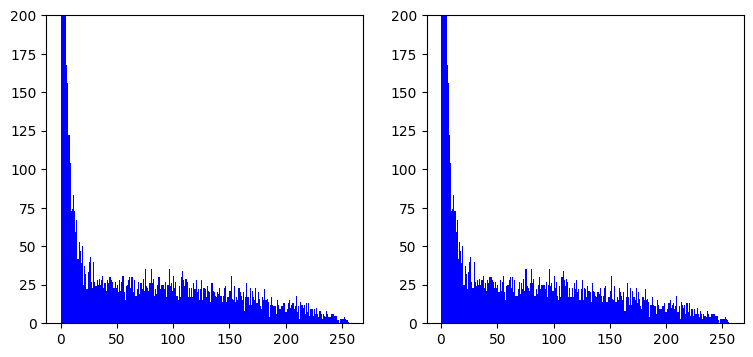

In [18]:
# probamos primero a normalizar respecto al maximo
frame = np.array(frames[50])
frame2 = normalize(frame) #  pl=1, ph=99
plot_compare(frame, frame2)
hist_compare(frame, frame2)

In [19]:
# normalize parece que no modifica nada la image, se ve igual, y no se aprecian cambios en el histograma

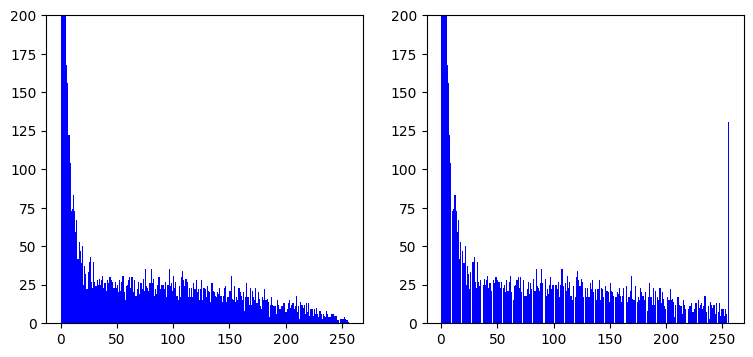

In [20]:
frame = np.array(frames[50])
frame2 = percentile_stretching(frame, pl=2, ph=99)
plot_compare(frame, frame2)
hist_compare(frame, frame2)

In [21]:
# percentile stretching mejora el contraste (el histograma se expande a la derecha), pero satura muchos valores a 255, hay un pico en el histograma

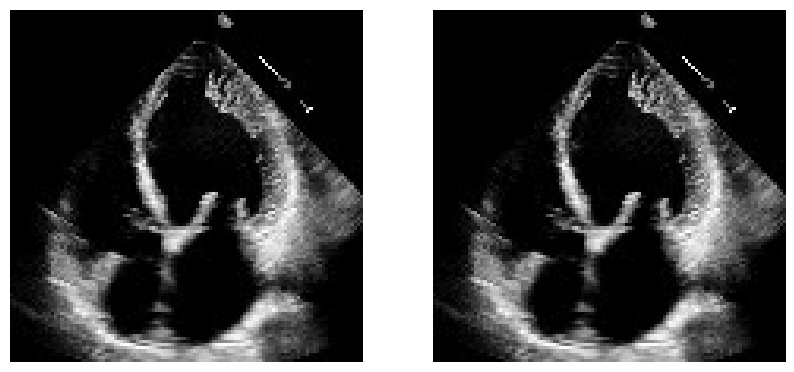

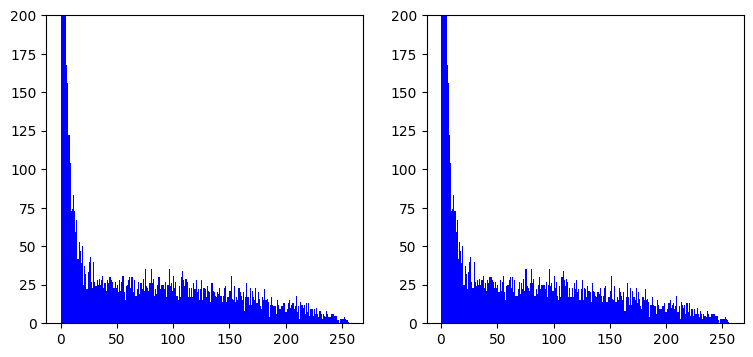

In [22]:
frame = np.array(frames[50])
frame2 = minmax_stretching(frame)
plot_compare(frame, frame2)
hist_compare(frame, frame2)

In [23]:
# minmax_stretching parece que no modifica nada la imagen

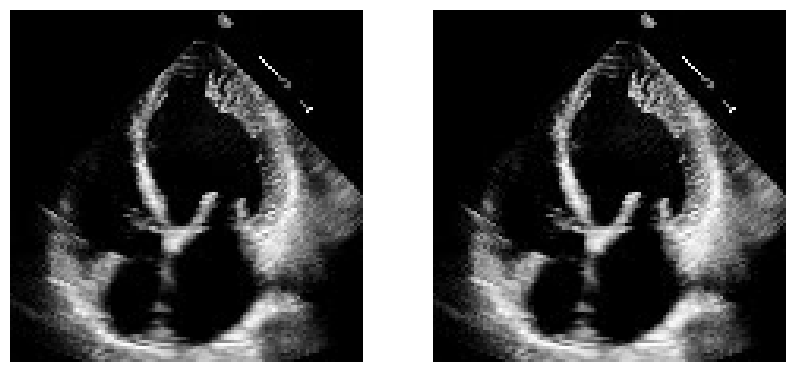

In [24]:
# ahora probamos BCET
frame = np.array(frames[50])
frame2 = bcet(frame, low=0, ex=50, high=255)
plot_compare(frame, frame2)
hist_compare(frame, frame2)

In [25]:
# aqui si que se aprecia una mejora notable, y sin saturar. Y en el histograma apreciamos
# que se ha expandido hacia la derecha, lo que significa que el contraste mejora.

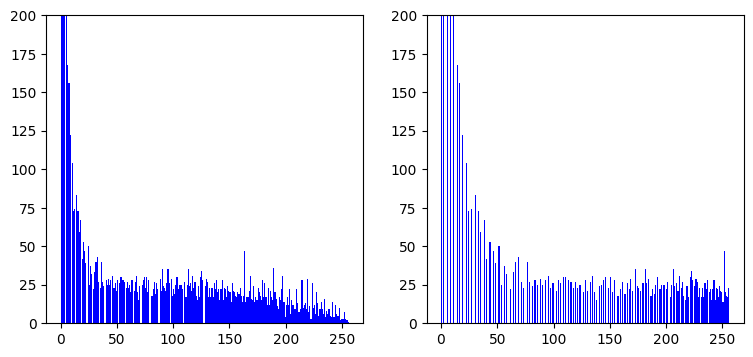

In [26]:
# vamos a probar bcet con otros parametros, y comparamos el resultado de los dos casos de BCET
frame = np.array(frames[50])
frame3 = bcet(frame, ex=110, low=0, high=255)
plot_compare(frame2, frame3)
hist_compare(frame2, frame3)

In [27]:
# con estos parametros, parece que satura mucho a 255, nos quedamos con la primera opción,
# que es la que mejor resultado da de todo lo que hemos probado

In [28]:
# vemos la intensidad media y desviación estandar del frame original
print(f"mean: {np.mean(frame)}")
print(f"std: {np.std(frame)}")

mean: 38.848852040816325
std: 61.889129122400234


In [29]:
# con BCET aumenta la intensidad media y la std, como era de esperar (30.85 en la frame original)
# en el segundo caso aumenta más, pero también aumentan mucho los pixels saturados a 255, se puede perder información
print(f"frame 2 mean: {np.mean(frame2)}")
print(f"frame 2 std: {np.std(frame2)}")

print(f"frame 3 mean: {np.mean(frame3)}")
print(f"frame 3 std: {np.std(frame3)}")

frame 2 mean: 44.01381392944003
frame 2 std: 67.64720546347314
frame 3 mean: 71.80446960468834
frame 3 std: 101.15334615183978


In [30]:
frames2 = [bcet(np.array(frame), low=0, ex=50, high=255) for frame in frames[0:20]]

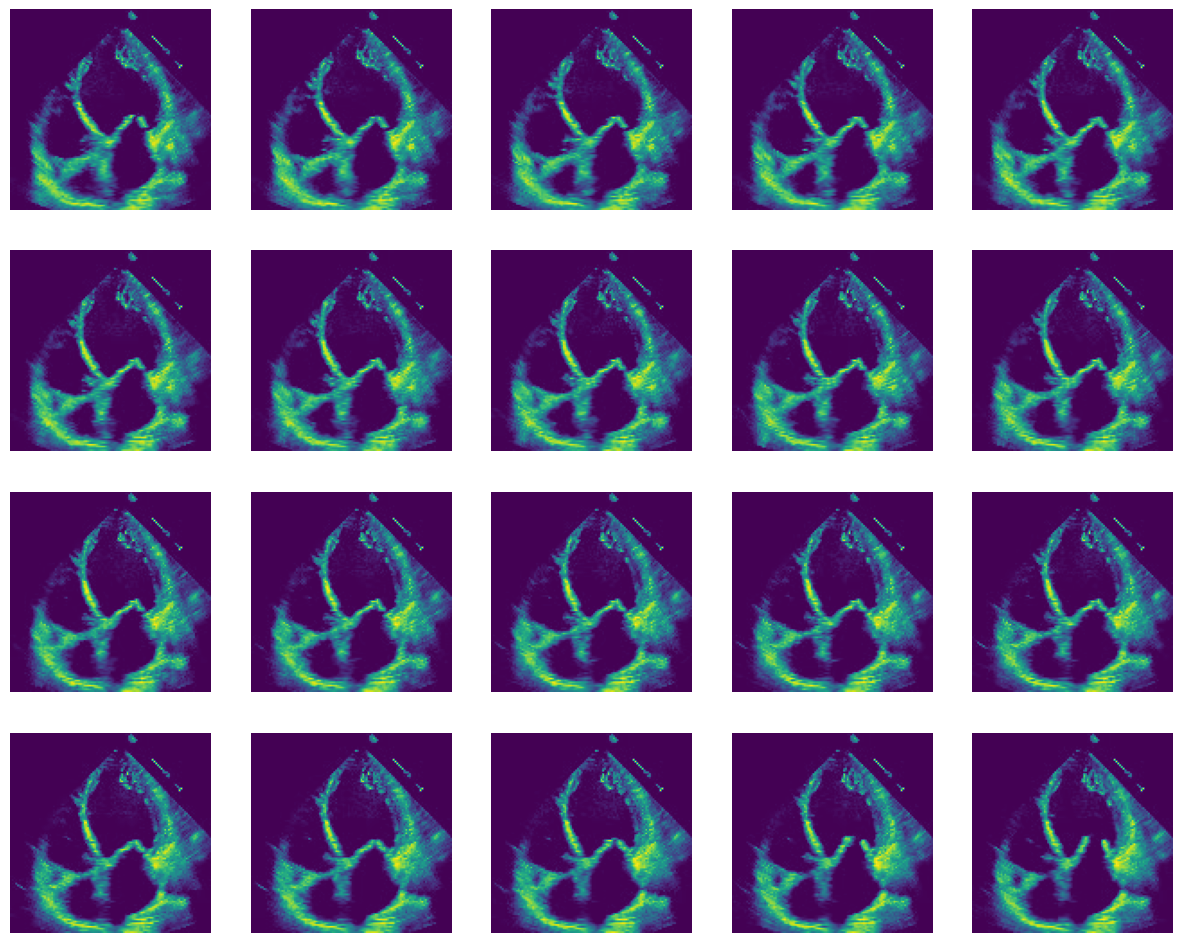

In [31]:
# frames originales
show_images(frames[0:20], nrows=4)

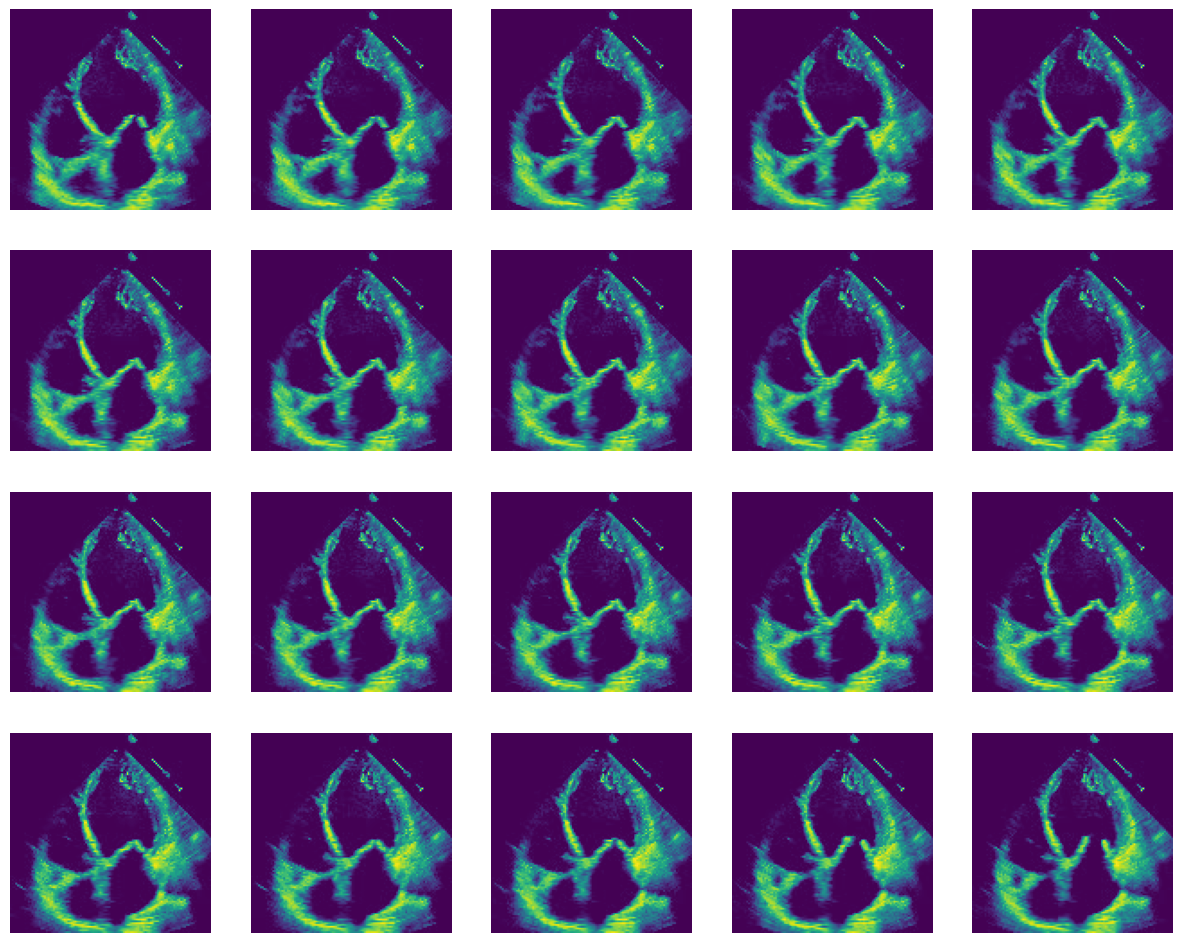

In [32]:
# frames con BCET
show_images(frames2[0:20], nrows=4)

In [33]:
# probamos con un caso de bajo FEVI
df[df['FEVI10'] == 3]['FileName'].values[0]

'0X1A58B506ED05C1D4'

In [34]:
video2 = av.open(str(data_path/'0X1A58B506ED05C1D4.avi'))
frames = [np.array(frame.to_image().convert("L")) for frame in video2.decode(0)]
frames2 = [bcet(np.array(frame), low=0, ex=50, high=255) for frame in frames[0:20]]

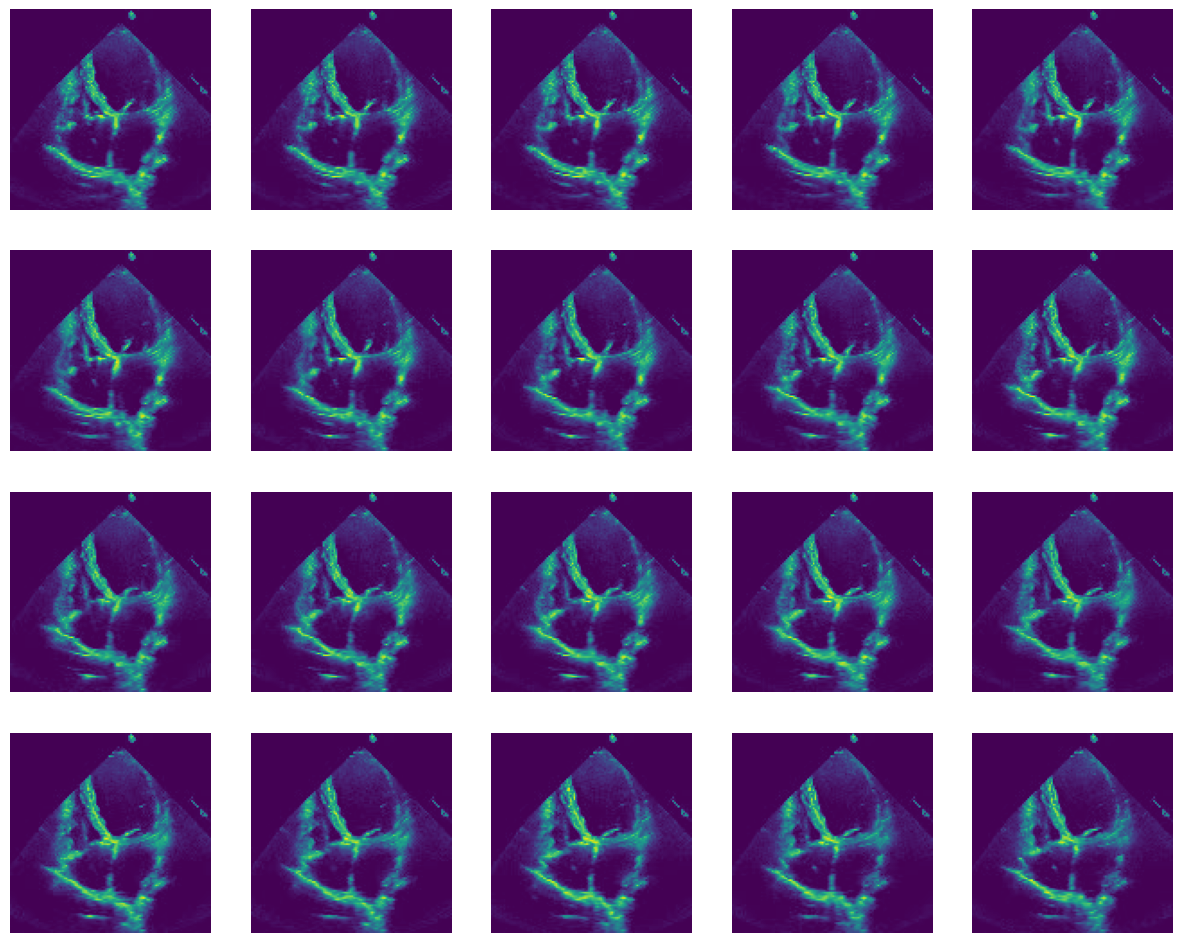

In [35]:
# frames originales
show_images(frames[0:20], nrows=4)

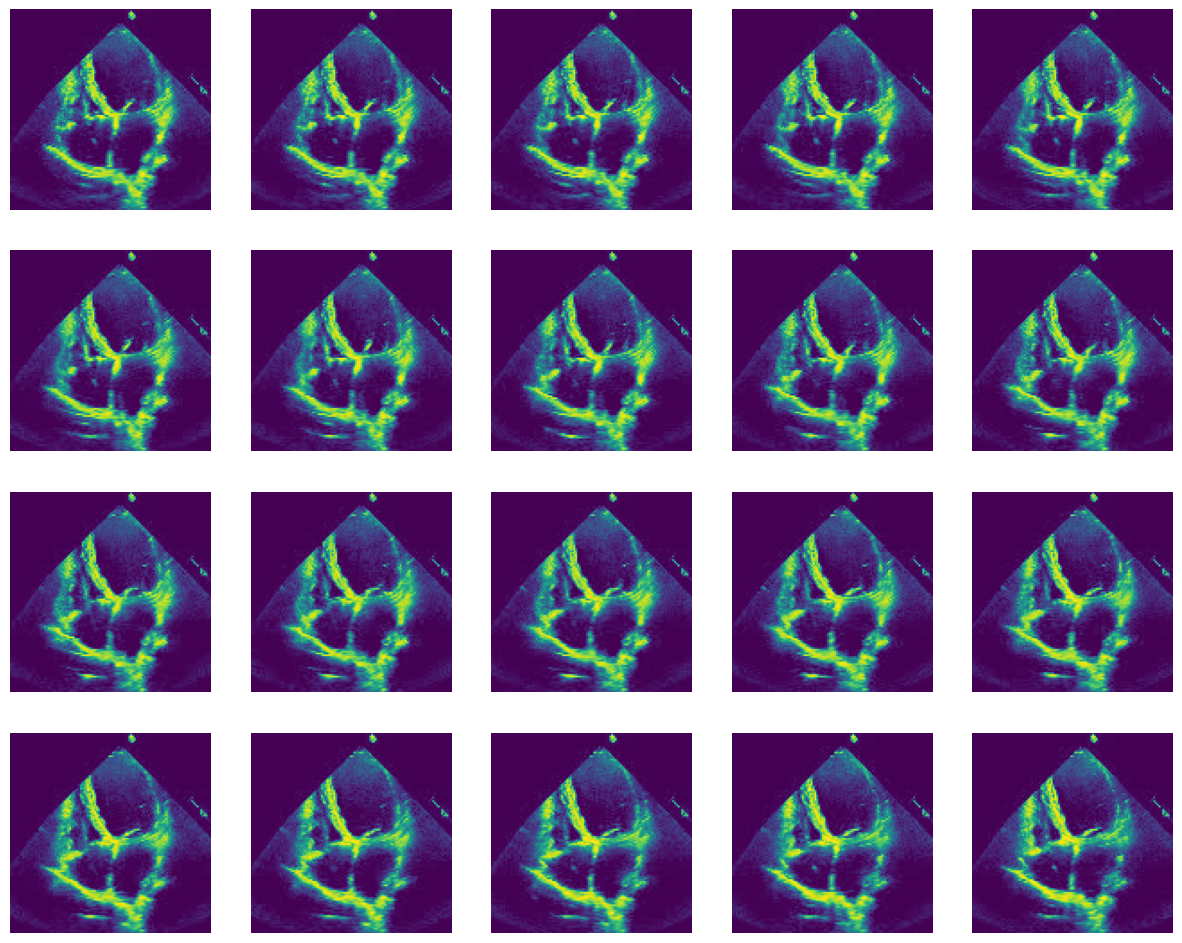

In [36]:
# frames con BCET
show_images(frames2[0:20], nrows=4)

In [39]:
# ahora buscamos un caso que no tenga problemas
df[df['FEVI10'] >=6]['FileName'].values[0]

'0X1A05829AEDF6C65'

In [40]:
video2 = av.open(str(data_path/'0X1AD3CDEC841DA50.avi'))
frames = [np.array(frame.to_image().convert("L")) for frame in video2.decode(0)]
frames2 = [bcet(np.array(frame), low=0, ex=50, high=255) for frame in frames[0:20]]

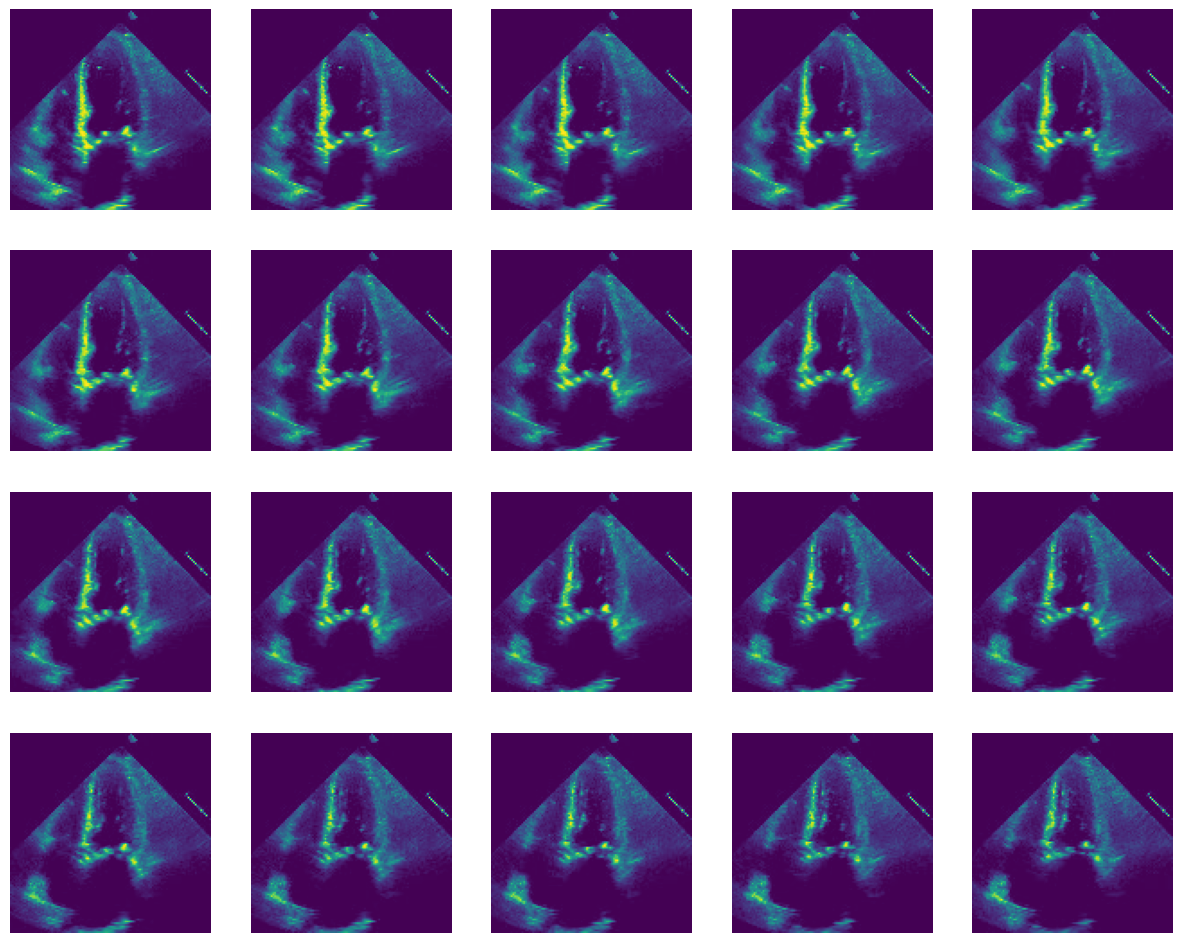

In [41]:
# frames originales
show_images(frames[0:20], nrows=4)

In [42]:
# frames con BCET
show_images(frames2[0:20], nrows=4)

In [43]:
# con las pruebas que hemos hecho, podemos decir que BCET mejora el contraste y ayuda a distinguir mejor el volumen de los ventriculos